In [1]:
import math
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy import optimize
import matplotlib.pyplot as plt
import scipy.constants as consts

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
n = 1

M = 7
K = 7
m = k = M

e1 = 2.2
e2 = 1

BETA_BEGIN = 0.01
BETA_STEP = 0.01
BETA_END = math.sqrt(e1) + BETA_STEP
BETA_POINTS = (BETA_END - BETA_BEGIN) / BETA_STEP

FREQ_SCALE = 1.0e9

radius = 0.02

In [3]:
jm_zeros_div_rad = special.jn_zeros(n, m) / radius
djm_zeros_div_rad = special.jnp_zeros(n, k) / radius

In [4]:
INTEG_WORKERS = -1

In [5]:
def er(r):
    return consts.epsilon_0 * (e1 + (e2 - e1) * r / radius)

def der(r):
    return consts.epsilon_0 * (e2 - e1) / radius

der_is_const = True

In [6]:
def denom(r, BETA, w):
    return (er(r) * consts.mu_0 * w**2 - BETA**2)

In [7]:
def unint_a(r, BETA, w, alpha_nm, kapa_nk):
    return der(r) * special.jv(n, alpha_nm*r) * special.jv(n, kapa_nk*r) / denom(r, BETA, w)**2

In [8]:
def submatrix_a(BETA, w, kapa_nk, alpha_nm, points=[]):
    coeff = -BETA * consts.mu_0 * w**2 * n
    integ = integrate.quad_vec(unint_a, 0, radius, epsabs=EPSABS, workers=INTEG_WORKERS, 
                               args=(BETA, w, alpha_nm, kapa_nk),
                               points=points)
    
    return coeff * integ[0]

In [9]:
def unint_b_1(r, BETA, w, kapa_nk, kapa_nk_):    
    return  r * special.jv(n, kapa_nk * r) * special.jv(n, kapa_nk_ * r) /  denom(r, BETA, w)

def unint_b_2(r, BETA, w, kapa_nk, kapa_nk_):
    return der(r) * r * special.jvp(n, kapa_nk * r) * special.jv(n, kapa_nk_ * r) / denom(r, BETA, w) ** 2

def unint_b_3(r, BETA, w, kapa_nk, kapa_nk_):
    return r * special.jv(n, kapa_nk * r) * special.jv(n, kapa_nk_ * r)

In [10]:
def submatrix_b(BETA, w, kapa_nk, kapa_nk_, points=[]):
    coeff1 = -w * consts.mu_0 * kapa_nk ** 2
    coeff2 = -w ** 3 * consts.mu_0 ** 2  * kapa_nk
    coeff3 = consts.mu_0 * w
    
    integ1 = integrate.quad_vec(unint_b_1, 0, radius, epsabs=EPSABS, workers=INTEG_WORKERS, 
                               args=(BETA, w, kapa_nk, kapa_nk_),
                               points=points)
    integ2 = integrate.quad_vec(unint_b_2, 0, radius, epsabs=EPSABS, workers=INTEG_WORKERS, 
                               args=(BETA, w, kapa_nk, kapa_nk_),
                               points=points)
    integ3 = integrate.quad_vec(unint_b_3, 0, radius, epsabs=EPSABS, workers=INTEG_WORKERS, 
                               args=(BETA, w, kapa_nk, kapa_nk_))
    
    return coeff1 * integ1[0] + coeff2 * integ2[0]+ coeff3 * integ3[0] 

In [11]:
def unint_c_1(r, BETA, w, alpha_nm, alpha_nm_):
    return r * er(r) * special.jv(n, alpha_nm * r) * special.jv(n, alpha_nm_ * r) / denom(r, BETA, w)

def unint_c_2(r, BETA, w, alpha_nm, alpha_nm_):
    return der(r) * r * special.jvp(n, alpha_nm * r) * special.jv(n, alpha_nm_ * r) / denom(r, BETA, w) ** 2

def unint_c_3(r, BETA, w, alpha_nm, alpha_nm_):
    return r * er(r) * special.jv(n, alpha_nm * r) * special.jv(n, alpha_nm_ * r)

In [12]:
def submatrix_c(BETA, w, alpha_nm, alpha_nm_, points=[]):
    coeff1 = -w * alpha_nm ** 2 
    coeff2 = -w * BETA ** 2 * alpha_nm
    coeff3 = w
    
    integ1 = integrate.quad_vec(unint_c_1, 0, radius, epsabs=EPSABS, workers=INTEG_WORKERS, 
                               args=(BETA, w, alpha_nm, alpha_nm_),
                               points=points)
    
    integ2 = integrate.quad_vec(unint_c_2, 0, radius, epsabs=EPSABS, workers=INTEG_WORKERS, 
                               args=(BETA, w, alpha_nm, alpha_nm_),
                               points=points)
    
    integ3 = integrate.quad_vec(unint_c_3, 0, radius, epsabs=EPSABS, workers=INTEG_WORKERS, 
                               args=(BETA, w, alpha_nm, alpha_nm_))
    
    return coeff1 * integ1[0] + coeff2 * integ2[0] + coeff3 * integ3[0]

In [13]:
def submatrix_d(BETA, w, kapa_nk, alpha_nm, points=[]):    
    return submatrix_a(BETA, w, kapa_nk, alpha_nm)

In [14]:
def find_denom_zeros(BETA, w):
    rs = np.linspace(0, radius, 1000)
    den_values = denom(rs, BETA, w)
    bounds = get_sign_changes_bounds(den_values, rs)
    res = []
    for bound in bounds:
        root = find_root_in_bound(denom, bound[0], bound[1], args=(BETA, w), exact=True)
        res.append(root)
    return res     

In [15]:
def calc_det(beta, w, n, verb=False):
    k0 = w / consts.speed_of_light
    BETA = beta * k0
    
    jm_zeros_div_rad = special.jn_zeros(n, m) / radius
    djm_zeros_div_rad = special.jnp_zeros(n, k) / radius
    
    matrix = np.empty([m+k, m+k])
    
    special_integ_points = find_denom_zeros(BETA,  w)
    
    
    matrix[0:m, 0:m] = submatrix_a(BETA, w,
                            djm_zeros_div_rad.reshape(m, 1), 
                            jm_zeros_div_rad, 
                            points=special_integ_points)
    
    matrix[0:m, m:m+k+1] = submatrix_b(BETA, w,
                            djm_zeros_div_rad.reshape(m, 1), 
                            djm_zeros_div_rad,
                            points=special_integ_points)
    
    matrix[m:m+k+1, 0:m] = submatrix_c(BETA, w,
                            jm_zeros_div_rad, 
                            jm_zeros_div_rad.reshape(m, 1),
                            points=special_integ_points)
    
    
    matrix[m:m+k+1, m:m+k+1] = submatrix_d(BETA, w,
                            djm_zeros_div_rad, 
                            jm_zeros_div_rad.reshape(m, 1),
                            points=special_integ_points)
    
    det = np.linalg.det(matrix)
    
    if verb:
        print(f"beta = {beta}\t det = {det}")
    
    return det

v_calc_det = np.vectorize(calc_det)

def calc_det_b(beta_x, w):
    return v_calc_det(beta_x, w, n, False)

In [16]:
def find_root_in_bound(fn, arg_low, arg_high, args=(), exact=True):
    if exact:
        return optimize.brentq(fn, arg_low, arg_high, args=args)
    else:
        return (arg_low + arg_high) / 2

In [17]:
def get_results(fs, betas, exact=True):
    res = []
    for f in fs:
        w = 2 * math.pi * f * FREQ_SCALE
        print(f"f = {f}, w = {w} ...")    
            
        dets = v_calc_det(betas, w, n)
        bounds = get_sign_changes_bounds(dets, betas)
        for bound in bounds:
            try:
                root = find_root_in_bound(calc_det_b, bound[0], bound[1], 
                                          args=(w), 
                                          exact=exact)
                if root > BETA_BEGIN:
                    print(f"root found: {root}")
                    res.append((w, root))
            except Exception as e:
                print(f"Err for bound {bound}: {e}")
                #raise
    return res

In [18]:
def get_sign_changes_bounds(vect, args):
    v_zero_crossings = np.where(np.diff(np.sign(vect)).astype("bool"))[0]
    v_zero_crossings = v_zero_crossings[~np.isnan(vect[v_zero_crossings]) & ~np.isnan(vect[v_zero_crossings+1])]
    
    if len(v_zero_crossings) == 0:
        return []
    
    arg_low, arg_high = args[v_zero_crossings], args[v_zero_crossings+1]
    
    return list(zip(arg_low, arg_high))

In [19]:
def plot_results(results):
    figsize = (20, 10)
    plt.figure(figsize=figsize)

    plt.plot(*zip(*results), '.')

    plt.title("Dispersion curves")
    plt.show()

In [20]:
EPSABS = 1.0e-7
fs = np.linspace(3.5, 75, 100)
betas = np.linspace(BETA_BEGIN, BETA_END, int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0056796162836488
root found: 1.4630614195969154
f = 4.222222222222222, w = 26529004630.313812 ...
root found: 0.6463414646979954
root found: 1.0087846166661323
f = 4.944444444444445, w = 31066860685.499065 ...
root found: 0.8478603021710461
root found: 1.0023684781575293
root found: 1.469980213498684
f = 5.666666666666666, w = 35604716740.68432 ...
root found: 0.9572947117673201
root found: 1.0050294416436176
root found: 1.4699629091966688
f = 6.388888888888889, w = 40142572795.86958 ...
root found: 1.46994812329692
f = 7.111111111111111, w = 44680428851.05483 ...
root found: 1.4699344299840247
f = 7.833333333333333, w = 49218284906.2401 ...
root found: 0.41202685583411724
root found: 1.4699222482701282
f = 8.555555555555555, w = 53756140961.42535 ...
root found: 0.6072273754046473
root found: 1.469911360053503
f = 9.277777777777779, w = 58293997016.61061 ...
root found: 0.7220738460766696
root found: 1.469901574767896
f = 10.0, w = 6283

root found: 1.2338920003263767
root found: 1.4670404855478234
f = 33.111111111111114, w = 208043246837.7241 ...
root found: 0.4066662981157669
root found: 0.6465135798029141
root found: 0.7961745341953858
root found: 0.9171978970836927
root found: 0.9837441375494927
root found: 1.2140981441586038
root found: 1.2348357618358918
root found: 1.4669739854027124
f = 33.83333333333333, w = 212581102892.9093 ...
root found: 0.47269774524470753
root found: 0.6821133833197928
root found: 0.818874102817135
root found: 0.932824492038441
root found: 0.9927657423688137
root found: 1.2188134908988428
root found: 1.2353834517879279
root found: 1.4669074598547163
f = 34.55555555555556, w = 217118958948.09457 ...
root found: 0.1391979645037743
root found: 0.5270562227695097
root found: 0.713815973231706
root found: 0.8394701483817204
root found: 0.9472167208799294
root found: 1.0021262704903524
root found: 1.1248537730215475
root found: 1.1381552232357453
root found: 1.2241372810303415
root found: 1.23

root found: 0.4895155270255118
root found: 0.6011035872583405
root found: 0.8037277881508098
root found: 0.8768280015524059
root found: 0.9484105633937006
root found: 1.2828760108631954
root found: 1.303547496124192
root found: 1.4654291022491273
f = 50.44444444444444, w = 316951792162.1702 ...
root found: 0.5187837721198353
root found: 0.6218997106802201
root found: 0.8173628964601587
root found: 0.887100420030355
root found: 0.9558920584370515
root found: 1.2072948139989286
root found: 1.2152581812958823
root found: 1.2849507126241964
root found: 1.3050903146315445
root found: 1.4653612156825193
f = 51.166666666666664, w = 321489648217.35547 ...
root found: 0.5452065946742386
root found: 0.641090667376448
root found: 0.8300901784426519
root found: 0.896735055586809
root found: 0.962852161905013
root found: 1.207589236012997
root found: 1.2192599789877963
root found: 1.2870323355535234
root found: 1.306713541192815
root found: 1.4652932860601056
f = 51.888888888888886, w = 32602750427

root found: 1.3162490768110704
root found: 1.337724809014234
root found: 1.4640677526987493
f = 64.88888888888889, w = 407708913265.87537 ...
root found: 0.8043393855432545
root found: 0.8449985728269634
root found: 0.9664435493348015
root found: 1.028097285831939
root found: 1.0478201245878076
root found: 1.247234174544339
root found: 1.2620788875909432
root found: 1.3175048327518326
root found: 1.3384867983641004
root found: 1.4639998180507752
f = 65.61111111111111, w = 412246769321.06067 ...
root found: 0.8115832952265932
root found: 0.8510365272519759
root found: 0.9701876640509646
root found: 1.0306441530223924
root found: 1.050578820820144
root found: 1.2491707298119663
root found: 1.2633739690874068
root found: 1.318772843947647
root found: 1.339170701891178
root found: 1.4639319397469515
f = 66.33333333333334, w = 416784625376.246 ...
root found: 0.8184830514879763
root found: 0.8568046052441711
root found: 0.9737224090315232
root found: 1.0333679479449773
root found: 1.0528848

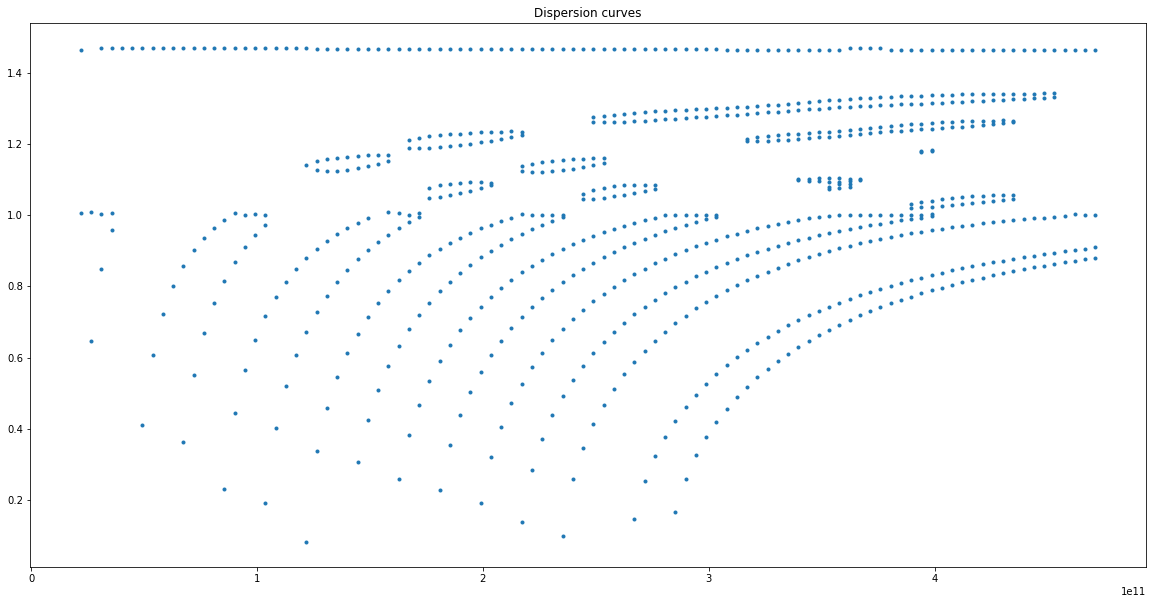

In [21]:
plot_results(results)

In [22]:
EPSABS = 1.0e-8
fs = np.linspace(3.5, 75, 100)
betas = np.linspace(BETA_BEGIN, BETA_END, int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0054258117010293
f = 4.222222222222222, w = 26529004630.313812 ...
root found: 0.6463414646979954
root found: 1.0000190665140498
f = 4.944444444444445, w = 31066860685.499065 ...
root found: 0.8478603021710461
root found: 1.0023684781575293
root found: 1.4645523462345693
f = 5.666666666666666, w = 35604716740.68432 ...
root found: 0.9572947117673201
root found: 1.0013661314265256
root found: 1.4691549138878348
f = 6.388888888888889, w = 40142572795.86958 ...
f = 7.111111111111111, w = 44680428851.05483 ...
f = 7.833333333333333, w = 49218284906.2401 ...
root found: 0.41202685583411724
root found: 1.467912986727905
f = 8.555555555555555, w = 53756140961.42535 ...
root found: 0.6072273754046473
f = 9.277777777777779, w = 58293997016.61061 ...
root found: 0.7220738460766696
f = 10.0, w = 62831853071.79586 ...
root found: 0.8005158937757075
f = 10.722222222222221, w = 67369709126.98112 ...
root found: 0.3641839792378708
root found: 0.8578487

root found: 0.09877071702116497
root found: 0.4918901826825642
root found: 0.6807565730400981
root found: 0.8127799705535691
root found: 0.9053985541942235
root found: 0.9949059851412974
root found: 1.4665741716540515
f = 38.166666666666664, w = 239808239224.02087 ...
root found: 0.2580342420114058
root found: 0.5379677180323778
root found: 0.7092562036318453
root found: 0.8323688401042968
root found: 0.9186046404719506
root found: 1.1312394184506769
root found: 1.4665073434570688
f = 38.888888888888886, w = 244346095279.20612 ...
root found: 0.3465656202589637
root found: 0.5779727481849527
root found: 0.7350656638493402
root found: 0.8503903996020635
root found: 0.930752143303794
root found: 1.466440450191162
f = 39.61111111111111, w = 248883951334.39136 ...
root found: 0.4129944246144662
root found: 0.6132558299810852
root found: 0.7585644485682125
root found: 0.8670193081899924
root found: 0.9419383762594382
root found: 1.4663734899130716
f = 40.333333333333336, w = 253421807389.57

root found: 0.7306261670652543
root found: 0.7845435826105192
root found: 0.9271364907242017
root found: 0.9719936700974574
root found: 1.2306617427422808
root found: 1.2445769805826126
root found: 1.3070982169981218
root found: 1.3299388695446739
root found: 1.4697582708648518
f = 59.833333333333336, w = 375943920879.57855 ...
root found: 0.7417008254581439
root found: 0.793513436453776
root found: 0.9331227991313479
root found: 0.9767884801503295
root found: 1.2330013238731639
root found: 1.2473985386539943
root found: 1.3084719483801948
root found: 1.3311482978976314
root found: 1.46975790306115
f = 60.55555555555556, w = 380481776934.76385 ...
root found: 0.7521600372993655
root found: 0.8020214913595013
root found: 0.9387632118614496
root found: 0.9813322633801246
root found: 1.007314723156898
root found: 1.235237573485387
root found: 1.2500697597279171
root found: 1.3098080583046567
root found: 1.3325582661848974
root found: 1.4644080226382137
f = 61.27777777777778, w = 385019632

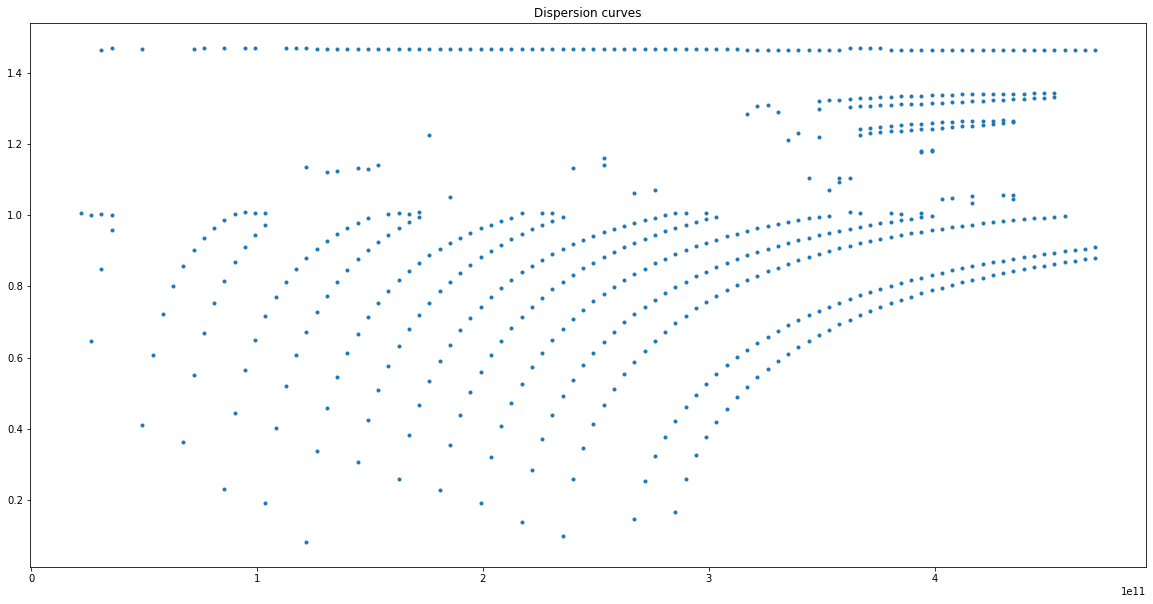

In [23]:
plot_results(results)

In [24]:
EPSABS = 1.0e-9
fs = np.linspace(3.5, 75, 100)
betas = np.linspace(BETA_BEGIN, BETA_END, int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0054258117010293
f = 4.222222222222222, w = 26529004630.313812 ...
root found: 0.6463414646979952
root found: 1.000632663062972
f = 4.944444444444445, w = 31066860685.499065 ...
root found: 0.847860302171046
root found: 1.0023684781575293
root found: 1.4649269401371323
f = 5.666666666666666, w = 35604716740.68432 ...
root found: 0.9572947117673198
root found: 1.0013661314265256
root found: 1.4657248894773116
f = 6.388888888888889, w = 40142572795.86958 ...
f = 7.111111111111111, w = 44680428851.05483 ...
f = 7.833333333333333, w = 49218284906.2401 ...
root found: 0.412026855834117
f = 8.555555555555555, w = 53756140961.42535 ...
root found: 0.6072273754046471
f = 9.277777777777779, w = 58293997016.61061 ...
root found: 0.7220738460766696
f = 10.0, w = 62831853071.79586 ...
root found: 0.8005158937757075
f = 10.722222222222221, w = 67369709126.98112 ...
root found: 0.3641839792378707
root found: 0.857848796632306
f = 11.444444444444445, w

root found: 0.41299442461446634
root found: 0.6132558299810861
root found: 0.7585644485682124
root found: 0.8670193081899926
root found: 0.9419383762594382
f = 40.333333333333336, w = 253421807389.57666 ...
root found: 0.46707794180117934
root found: 0.644732402416267
root found: 0.780053823385029
root found: 0.8824032172638817
root found: 0.952249415283734
root found: 1.144111093638084
root found: 1.1602657790738804
root found: 1.4629915298088871
f = 41.05555555555556, w = 257959663444.76193 ...
root found: 0.5129247953429392
root found: 0.6730591759239569
root found: 0.7997775576812405
root found: 0.8966681673622787
root found: 0.9617622408936934
root found: 1.4636618511775947
f = 41.77777777777778, w = 262497519499.94714 ...
root found: 0.5527477543436843
root found: 0.6987274709243755
root found: 0.8179360191986225
root found: 0.9099226678948948
root found: 0.9705462306046708
f = 42.5, w = 267035375555.13242 ...
root found: 0.1469965287993464
root found: 0.5879093676735212
root fou

root found: 0.9624765739881279
root found: 1.048955506079074
root found: 1.314359901765683
root found: 1.4640640761947148
f = 64.88888888888889, w = 407708913265.87537 ...
root found: 0.8043393855432545
root found: 0.8449985728269634
root found: 0.9664435493348014
root found: 1.0478481698729718
root found: 1.4639961326155686
f = 65.61111111111111, w = 412246769321.06067 ...
root found: 0.8115832952265932
root found: 0.8510365272519758
root found: 0.9701876640509646
root found: 1.4639282455890616
f = 66.33333333333334, w = 416784625376.246 ...
root found: 0.8184830514879763
root found: 0.8568046052441711
root found: 0.9737224090315231
root found: 1.0333652298176585
root found: 1.340439026636488
root found: 1.4638604233131947
f = 67.05555555555556, w = 421322481431.43115 ...
root found: 0.825060128931702
root found: 0.8623187210143431
root found: 0.9770604857110343
root found: 1.463792674680589
f = 67.77777777777777, w = 425860337486.61633 ...
root found: 0.8313342322048235
root found: 0

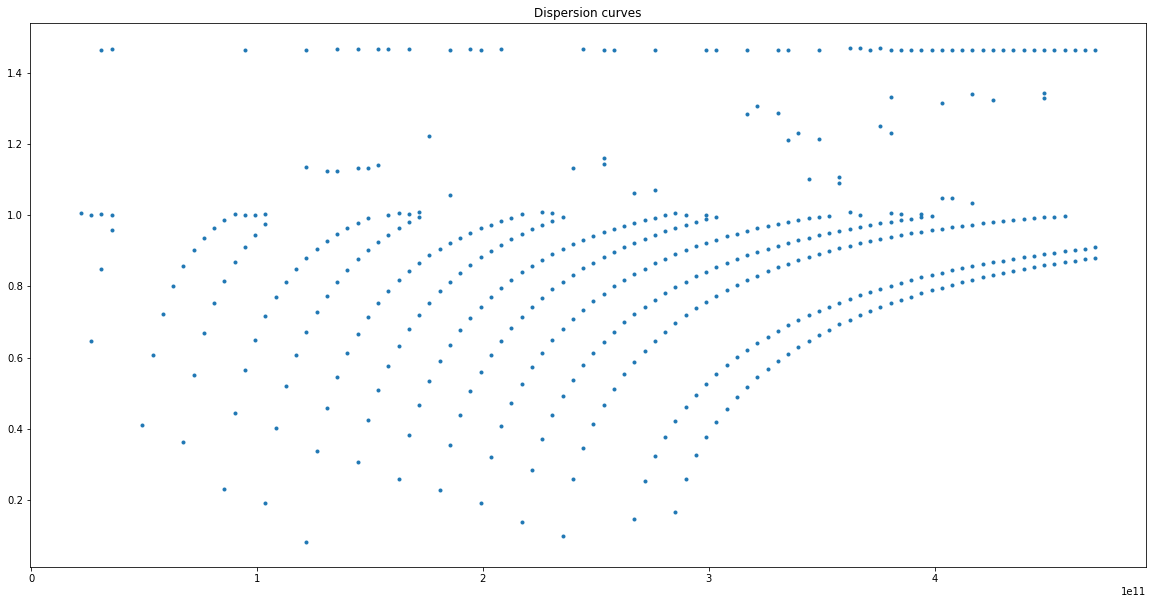

In [25]:
plot_results(results)

In [26]:
EPSABS = 1.0e-10
fs = np.linspace(3.5, 75, 100)
betas = np.linspace(BETA_BEGIN, BETA_END, int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0054258117010293
f = 4.222222222222222, w = 26529004630.313812 ...
root found: 0.6463414646979952
root found: 1.000632663062972
f = 4.944444444444445, w = 31066860685.499065 ...
root found: 0.847860302171046
root found: 1.0023684781575293
root found: 1.4657855701741431
f = 5.666666666666666, w = 35604716740.68432 ...
root found: 0.9572947117673198
root found: 1.0013661314265256
root found: 1.4642940893888206
f = 6.388888888888889, w = 40142572795.86958 ...
f = 7.111111111111111, w = 44680428851.05483 ...
f = 7.833333333333333, w = 49218284906.2401 ...
root found: 0.412026855834117
f = 8.555555555555555, w = 53756140961.42535 ...
root found: 0.6072273754046471
f = 9.277777777777779, w = 58293997016.61061 ...
root found: 0.7220738460766696
f = 10.0, w = 62831853071.79586 ...
root found: 0.8005158937757075
f = 10.722222222222221, w = 67369709126.98112 ...
root found: 0.3641839792378707
root found: 0.857848796632306
f = 11.444444444444445, w

root found: 0.46707794180117934
root found: 0.644732402416267
root found: 0.780053823385029
root found: 0.8824032172638817
root found: 0.952249415283734
root found: 1.1459379814836863
root found: 1.1602644866209555
f = 41.05555555555556, w = 257959663444.76193 ...
root found: 0.5129247953429392
root found: 0.6730591759239569
root found: 0.7997775576812405
root found: 0.8966681673622787
root found: 0.9617622408936934
f = 41.77777777777778, w = 262497519499.94714 ...
root found: 0.5527477543436843
root found: 0.6987274709243755
root found: 0.8179360191986225
root found: 0.9099226678948948
root found: 0.9705462306046708
f = 42.5, w = 267035375555.13242 ...
root found: 0.1469965287993464
root found: 0.5879093676735212
root found: 0.7221169592155937
root found: 0.8346960799037716
root found: 0.9222608298024896
root found: 0.9786637464733356
root found: 1.0613919723586567
f = 43.22222222222222, w = 271573231610.3177 ...
root found: 0.2534128443209408
root found: 0.6193235404857786
root found

root found: 0.9770604857110343
f = 67.77777777777777, w = 425860337486.61633 ...
root found: 0.8313342322048235
root found: 0.8675935749826322
root found: 0.980213848092751
root found: 1.3220305419381755
f = 68.5, w = 430398193541.8017 ...
root found: 0.837323483735876
root found: 0.872642770327844
root found: 0.9831937302061854
f = 69.22222222222221, w = 434936049596.9869 ...
root found: 0.8430445868594609
root found: 0.8774789158027649
root found: 0.9860106544155498
root found: 1.4633097230803451
f = 69.94444444444444, w = 439473905652.1722 ...
root found: 0.8485129681790902
root found: 0.8821137167429223
root found: 0.9886744080971389
root found: 1.4633903908023158
f = 70.66666666666667, w = 444011761707.3574 ...
root found: 0.853742902321999
root found: 0.8865580558850159
root found: 0.9911939536700117
f = 71.38888888888889, w = 448549617762.54266 ...
root found: 0.8587476216836747
root found: 0.8908220653521053
root found: 0.993577162545429
root found: 1.3279512835484717
root foun

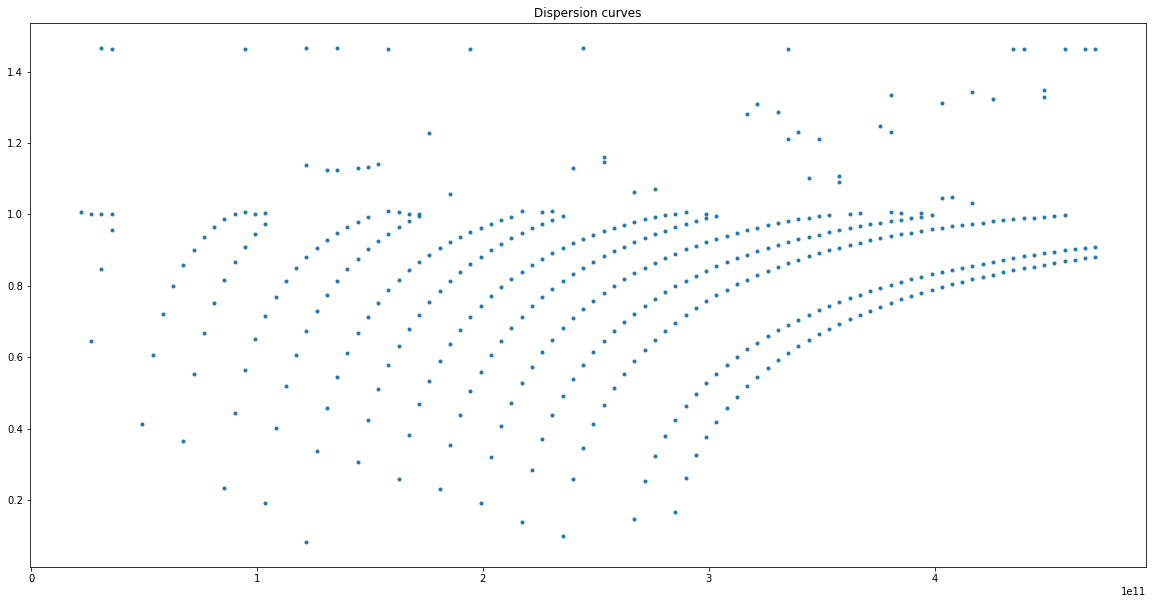

In [27]:
plot_results(results)

In [28]:
EPSABS = 1.0e-7
fs = np.linspace(3.5, 75, 100)
betas = np.linspace(BETA_BEGIN, BETA_END, 3*int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.000003509967848
root found: 1.4700197286258894
f = 4.222222222222222, w = 26529004630.313812 ...
root found: 0.6463414646983072
root found: 1.4699987232719598
f = 4.944444444444445, w = 31066860685.499065 ...
root found: 0.8478603021711099
root found: 1.0009956415867047
root found: 1.469980213498688
f = 5.666666666666666, w = 35604716740.68432 ...
root found: 0.9572947117674184
root found: 1.0006117127441103
root found: 1.4699629091968514
f = 6.388888888888889, w = 40142572795.86958 ...
root found: 1.469948123297003
f = 7.111111111111111, w = 44680428851.05483 ...
root found: 1.2094151597620497
root found: 1.4699344299840493
f = 7.833333333333333, w = 49218284906.2401 ...
root found: 0.41202685583403603
root found: 1.0000000000027485
root found: 1.469922248270112
f = 8.555555555555555, w = 53756140961.42535 ...
root found: 0.6072273754048868
root found: 1.000000000014706
root found: 1.4699113600538225
f = 9.277777777777779, w = 582939970

root found: 1.211907503274135
root found: 1.2120031716082407
root found: 1.227296351425146
root found: 1.469792265743932
f = 30.22222222222222, w = 189891822616.98303 ...
root found: 0.43868875050411654
root found: 0.6764676052022673
root found: 0.8386514264805579
root found: 0.9372367521318058
root found: 1.0000000000143534
root found: 1.0052690883112478
root found: 1.0628609318721027
root found: 1.091289996454766
root found: 1.197748297891948
root found: 1.2119077636735778
root found: 1.2120040402185561
root found: 1.2294094388262988
root found: 1.469790656970973
f = 30.944444444444443, w = 194429678672.1683 ...
root found: 0.504933749202911
root found: 0.7117972247609541
root found: 0.8611541580128536
root found: 0.950667056051835
root found: 1.0000000000147318
root found: 1.0057808209436732
root found: 1.0693990798758626
root found: 1.092397107168464
root found: 1.2014804657941758
root found: 1.2119088879797093
root found: 1.212003700965377
root found: 1.2311688226199424
root found

root found: 0.14699652879935116
root found: 0.5879093676735967
root found: 0.7221169592151562
root found: 0.8346960799037717
root found: 0.9222608298024744
root found: 0.9786637464733356
root found: 1.0000000000148874
root found: 1.00674419552008
root found: 1.0630344401335563
root found: 1.0850439671882273
root found: 1.2119119977794302
root found: 1.2120155198712514
root found: 1.2642251856701412
root found: 1.2879655499593856
root found: 1.466104960707605
f = 43.22222222222222, w = 271573231610.3177 ...
root found: 0.253412844321387
root found: 0.619323540486372
root found: 0.7435286637882549
root found: 0.8501982791461733
root found: 0.9337648000379797
root found: 0.9861686759711247
root found: 0.9999916425099198
root found: 1.0064760577208476
root found: 1.068377035840472
root found: 1.0852005585338256
root found: 1.2119129592186089
root found: 1.2120156005836245
root found: 1.2653746314534697
root found: 1.290034549537342
root found: 1.4660376562825315
f = 43.94444444444444, w = 

root found: 1.320055860055047
root found: 1.4648850056993437
f = 56.22222222222222, w = 353254640603.6523 ...
root found: 0.6789879016640481
root found: 0.7432614589172215
root found: 0.8992402514689396
root found: 0.9499543027778111
root found: 1.0069401998374614
root found: 1.074086693706929
root found: 1.0802943256610034
root found: 1.0939643870923097
root found: 1.100647844208277
root found: 1.2119159088554492
root found: 1.2120212449324381
root found: 1.221113459412899
root found: 1.2351607288100244
root found: 1.3008860314578363
root found: 1.3223499670279293
root found: 1.4648168781237585
f = 56.94444444444444, w = 357792496658.8375 ...
root found: 0.6931373244694451
root found: 0.754482253426505
root found: 0.9068614375768813
root found: 0.9559321748250997
root found: 1.000000000014464
root found: 1.0758028176019263
root found: 1.0864814583291937
root found: 1.093514692110798
root found: 1.1006571110350418
root found: 1.1537634622678619
root found: 1.1574054361930919
root found

root found: 0.9999367966734889
root found: 1.007027203000835
root found: 1.039324570315473
root found: 1.0560379670504918
root found: 1.211945561027849
root found: 1.2120038160144533
root found: 1.2554987309941639
root found: 1.26596827088044
root found: 1.3226005452268919
root found: 1.3407815737949433
root found: 1.4637287280584301
f = 68.5, w = 430398193541.8017 ...
root found: 0.837323483735876
root found: 0.87264277032783
root found: 0.9831937302060553
root found: 0.9999427283281176
root found: 1.0070559054606791
root found: 1.0426587073256874
root found: 1.0567511956325246
root found: 1.2119491398827769
root found: 1.2119965011197193
root found: 1.2578474080057216
root found: 1.266243796427569
root found: 1.3238967649026632
root found: 1.3411761611487134
root found: 1.463661164207058
f = 69.22222222222221, w = 434936049596.9869 ...
root found: 0.8430445868594616
root found: 0.8774789158027657
root found: 0.9860106544154768
root found: 0.9999463477467732
root found: 1.006996914687

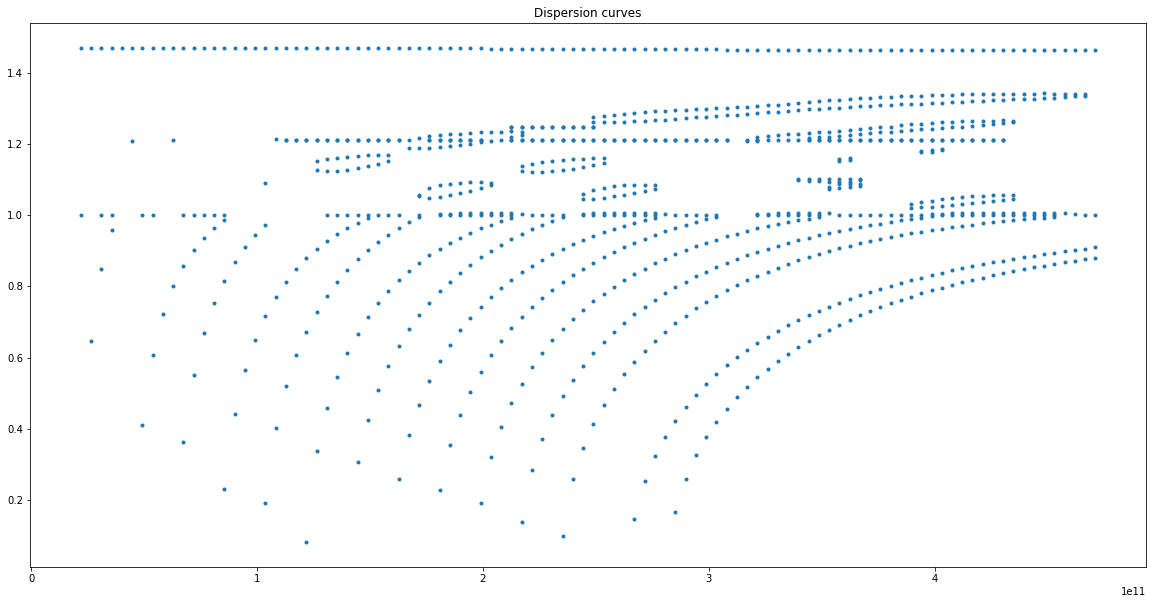

In [29]:
plot_results(results)

In [30]:
EPSABS = 1.0e-7
fs = np.linspace(3.5, 75, 100)
betas = np.linspace(BETA_BEGIN, BETA_END, 10*int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0466671504014884
root found: 1.1208604800831536
root found: 1.4700197286258785
root found: 1.4760363236708747
root found: 1.4762838712814321
f = 4.222222222222222, w = 26529004630.313812 ...
root found: 0.6463414646980504
root found: 1.046235070903252
root found: 1.0479515204832843
root found: 1.2903323619864269
root found: 1.291565858669197
root found: 1.4699987232719667
root found: 1.4760363773968064
root found: 1.4762838318350113
f = 4.944444444444445, w = 31066860685.499065 ...
root found: 0.8478603021711175
root found: 1.1396380492437415
root found: 1.1410086220523994
root found: 1.4699802134988114
root found: 1.4760364267485204
root found: 1.4762837960620536
f = 5.666666666666666, w = 35604716740.68432 ...
root found: 0.9572947117674229
root found: 1.0008228432206188
root found: 1.0474720284092187
root found: 1.4699629091966684
root found: 1.4760364780482127
root found: 1.4762837586628648
f = 6.388888888888889, w = 40142572795.8695

root found: 0.30565141572948007
root found: 0.6675243668681128
root found: 0.8762338304768041
root found: 0.9787521745790958
root found: 1.0051097874573511
root found: 1.046957806459854
root found: 1.0470048680113933
root found: 1.1315881260623657
root found: 1.1401249768176995
root found: 1.1402383725266176
root found: 1.1670603044012893
root found: 1.2906102756705058
root found: 1.2906824270954436
root found: 1.4679121920330518
root found: 1.4691689147878255
root found: 1.4698105255245912
root found: 1.476037245519131
root found: 1.4762832281386793
f = 23.72222222222222, w = 149051118120.31573 ...
root found: 0.42529647707981033
root found: 0.713679342346261
root found: 0.9021624004672928
root found: 0.9917295901350516
root found: 0.9999965834900987
root found: 1.0469586842373075
root found: 1.0470045107000063
root found: 1.1377171313091228
root found: 1.1689582626994945
root found: 1.2906103581793498
root found: 1.2906826204116741
root found: 1.4678436467547642
root found: 1.4760372

root found: 0.6465135798029149
root found: 0.796174534195419
root found: 0.9171978970836927
root found: 0.9837441375495559
root found: 1.000000000014846
root found: 1.0059223275075122
root found: 1.0469564893963372
root found: 1.0470059385657084
root found: 1.140113586457396
root found: 1.140289838822602
root found: 1.214098144158586
root found: 1.2348357618358974
root found: 1.2384944077843192
root found: 1.238721595334256
root found: 1.2906117884172212
root found: 1.2906857599314265
root found: 1.4669739854026937
root found: 1.476037495276468
root found: 1.4762830739471038
f = 33.83333333333333, w = 212581102892.9093 ...
root found: 0.4726977452447076
root found: 0.6821133833194489
root found: 0.8188741028172809
root found: 0.9328244920387342
root found: 0.9927657423691341
root found: 1.000000000013445
root found: 1.0051049848692335
root found: 1.046957021935462
root found: 1.0470058015881796
root found: 1.1401094498733604
root found: 1.140317306825742
root found: 1.2188134908987243


root found: 1.2906947704188296
root found: 1.4661721967130699
root found: 1.4760376510543092
root found: 1.4762829848490928
f = 42.5, w = 267035375555.13242 ...
root found: 0.14699652879935085
root found: 0.5879093676735963
root found: 0.7221169592156361
root found: 0.8346960799037442
root found: 0.9222608298028279
root found: 0.9786637464730411
root found: 1.0000000000147156
root found: 1.0067441955195697
root found: 1.0469566750118882
root found: 1.047006354699039
root found: 1.0630344401328662
root found: 1.0850439671879781
root found: 1.1401320630636191
root found: 1.1402578560783945
root found: 1.2642251856701838
root found: 1.2879655499594012
root found: 1.2906121269923763
root found: 1.2907005821870297
root found: 1.4661049607075929
root found: 1.4760376621894968
root found: 1.4762829787145124
f = 43.22222222222222, w = 271573231610.3177 ...
root found: 0.2534128443213845
root found: 0.6193235404861833
root found: 0.7435286637883214
root found: 0.8501982791461243
root found: 0.9

root found: 0.5912706026592586
root found: 0.6753946473586226
root found: 0.853120122614446
root found: 0.9142856744618163
root found: 0.9753387943003816
root found: 1.0000000000145381
root found: 1.0056018796225195
root found: 1.2103716308818047
root found: 1.2248339767939154
root found: 1.2906181814791444
root found: 1.310485205579055
root found: 1.4651573115255703
root found: 1.4760377951790211
root found: 1.4762829077524977
f = 53.333333333333336, w = 335103216382.91125 ...
root found: 0.6115412142634777
root found: 0.6908002924081648
root found: 0.8635508501863977
root found: 0.9222870923834272
root found: 0.9809225575992432
root found: 1.0000000000144906
root found: 1.0064273549504814
root found: 1.212414131464896
root found: 1.2273560535197645
root found: 1.2906203894432264
root found: 1.290689627484204
root found: 1.2932345480264085
root found: 1.312702198403792
root found: 1.3157135892660576
root found: 1.3157532940229486
root found: 1.4650892738823547
root found: 1.4760378032

root found: 1.3098080583045735
root found: 1.332558266184909
root found: 1.4644080226386178
root found: 1.4760378766254696
root found: 1.4762828657462084
f = 61.27777777777778, w = 385019632989.9491 ...
root found: 0.7620514335681415
root found: 0.8101002716730695
root found: 0.9440791374416041
root found: 0.9856398971756627
root found: 1.0000000000138187
root found: 1.0469540291465538
root found: 1.0470106148974159
root found: 1.1201685375478523
root found: 1.1204703507276723
root found: 1.140147911315879
root found: 1.140271069194302
root found: 1.2373752710139865
root found: 1.2526804326884164
root found: 1.2906293185118851
root found: 1.2906837373101243
root found: 1.311117557924346
root found: 1.3337985970586184
root found: 1.464339910594931
root found: 1.4760378832828176
root found: 1.4762828623167343
f = 62.0, w = 389557489045.13434 ...
root found: 0.7714175680203659
root found: 0.8177792427703333
root found: 0.9490904775402659
root found: 0.9897248479340987
root found: 1.000000

root found: 0.9886744080226918
root found: 0.9999484239583202
root found: 1.0068544104367088
root found: 1.3265425061041247
root found: 1.3417469993679927
root found: 1.463526365288783
root found: 1.4760379559236678
root found: 1.4762828242944699
f = 70.66666666666667, w = 444011761707.3574 ...
root found: 0.8537429023217245
root found: 0.8865580558850107
root found: 0.9911939533549844
root found: 0.9999493987097102
root found: 1.006624898933902
root found: 1.3279077109149013
root found: 1.3419146554461379
root found: 1.4634591576446667
root found: 1.476037961475044
root found: 1.476282821309291
f = 71.38888888888889, w = 448549617762.54266 ...
root found: 0.8587476216834024
root found: 0.8908220653525974
root found: 0.9935771610955207
root found: 0.9999495199769293
root found: 1.0062953341499958
root found: 1.329323894608499
root found: 1.3419916774082832
root found: 1.463392098915973
root found: 1.4760379669633785
root found: 1.4762828183417012
f = 72.11111111111111, w = 453087473817

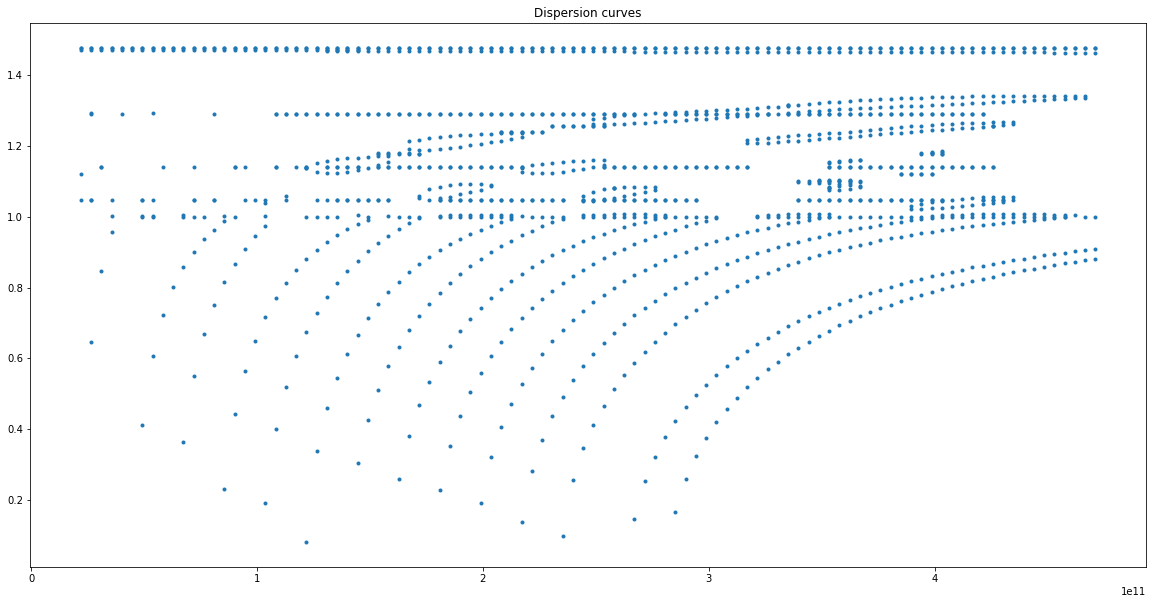

In [31]:
plot_results(results)

In [32]:
EPSABS = 1.0e-9
fs = np.linspace(3.5, 75, 100)
betas = np.linspace(BETA_BEGIN, BETA_END, 10*int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0463482929306571
root found: 1.120904686592029
f = 4.222222222222222, w = 26529004630.313812 ...
root found: 0.6463414646980504
root found: 1.0465183863315182
root found: 1.0471721241579122
root found: 1.2896980229311896
root found: 1.2911435817273742
f = 4.944444444444445, w = 31066860685.499065 ...
root found: 0.8478603021711175
root found: 1.1393437965978208
root found: 1.1407384065349082
f = 5.666666666666666, w = 35604716740.68432 ...
root found: 0.9572947117674229
root found: 1.000826866184799
root found: 1.0474053374677212
f = 6.388888888888889, w = 40142572795.86958 ...
root found: 1.29044486505004
f = 7.111111111111111, w = 44680428851.05483 ...
root found: 1.4761915504684193
f = 7.833333333333333, w = 49218284906.2401 ...
root found: 0.41202685583411963
root found: 1.0000000000090958
root found: 1.0026521528787968
root found: 1.0464696553232922
root found: 1.0470653102344587
f = 8.555555555555555, w = 53756140961.42535 ...
root

root found: 1.4760374207921667
root found: 1.4762831174007804
f = 30.22222222222222, w = 189891822616.98303 ...
root found: 0.4386887505041179
root found: 0.6764676052024646
root found: 0.8386514264803998
root found: 0.9372367521318062
root found: 0.9999999999988884
root found: 1.0913605067069905
root found: 1.476037437400685
root found: 1.4762831073285534
f = 30.944444444444443, w = 194429678672.1683 ...
root found: 0.5049337492028663
root found: 0.7117972247609564
root found: 0.8611541580129523
root found: 0.9506670560518358
root found: 1.0000000000001141
root found: 1.093095250593393
root found: 1.4760374536038652
root found: 1.47628309755996
f = 31.666666666666668, w = 198967534727.35358 ...
root found: 0.19165566726107133
root found: 0.5595878009328499
root found: 0.7430969405413362
root found: 0.8815710004814102
root found: 0.9627991413136437
root found: 1.476037469413842
root found: 1.4762830880844982
f = 32.388888888888886, w = 203505390782.5388 ...
root found: 0.32134515395999

root found: 1.2995491662613126
root found: 1.465628061519571
root found: 1.4760377356366612
root found: 1.4762829383241476
f = 48.27777777777778, w = 303338223996.6145 ...
root found: 0.4195933372691374
root found: 0.553685668459828
root found: 0.7733691972825301
root found: 0.8541400550664465
root found: 0.9317346123046658
root found: 0.9960086564575715
root found: 1.0001351664984852
root found: 1.2786887168104113
root found: 1.4760377429568972
root found: 1.4762829351436668
f = 49.0, w = 307876080051.7997 ...
root found: 0.45676077542963855
root found: 0.5784649612994257
root found: 0.7890969343606368
root found: 0.8658620539417985
root found: 0.9403712994348642
root found: 1.3024509921907677
root found: 1.4760377521124928
root found: 1.476282930301731
f = 49.72222222222222, w = 312413936106.985 ...
root found: 0.4895155270254808
root found: 0.6011035872583426
root found: 0.8037277881508097
root found: 0.8768280015523788
root found: 0.9484105633941278
root found: 1.4760377610797395
r

root found: 0.9664435493344693
root found: 1.0478032042782361
root found: 1.2911454445876696
root found: 1.4639961326155926
root found: 1.476037915052095
root found: 1.476282845866634
f = 65.61111111111111, w = 412246769321.06067 ...
root found: 0.8115832952264995
root found: 0.8510365272520695
root found: 0.9701876640512919
root found: 1.0000000000105576
root found: 1.2914762918549767
root found: 1.4639282455891216
root found: 1.4760379211281558
root found: 1.4762828426961998
f = 66.33333333333334, w = 416784625376.246 ...
root found: 0.8184830514879587
root found: 0.8568046052440328
root found: 0.9737224090315232
root found: 1.0000000000009763
root found: 1.4638604233134085
root found: 1.4760379271197535
root found: 1.47628283955939
f = 67.05555555555556, w = 421322481431.43115 ...
root found: 0.8250601289319361
root found: 0.862318721014346
root found: 0.9770604857108327
root found: 1.0074118267109622
root found: 1.3209067547985982
root found: 1.4637926746809495
root found: 1.476037

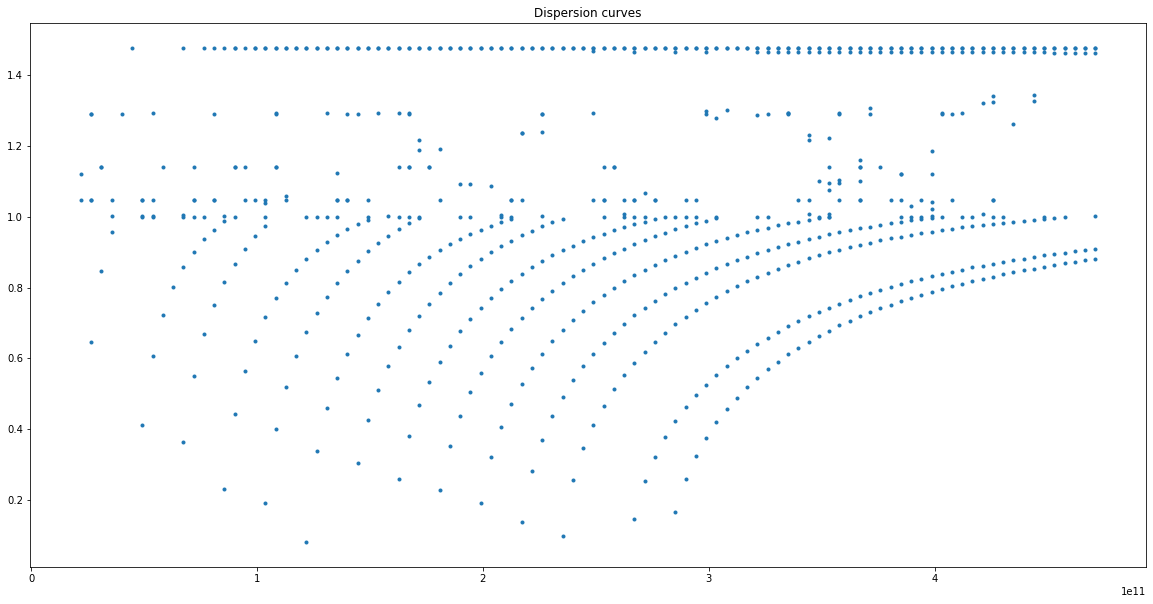

In [33]:
plot_results(results)

In [34]:
M = 10
K = 10
m = k = M

EPSABS = 1.0e-7
fs = np.linspace(3.5, 75, 120)
betas = np.linspace(BETA_BEGIN, BETA_END, int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0000000000008855
root found: 1.1399292325430619
root found: 1.1401521252385374
f = 4.100840336134453, w = 25766339747.089394 ...
root found: 0.5928957388754602
root found: 1.0000000000116787
root found: 1.4736342113848424
f = 4.701680672268908, w = 29541530919.050243 ...
root found: 0.7952735379938994
root found: 1.1400742005735511
root found: 1.140099883606829
root found: 1.4736047505288017
f = 5.302521008403361, w = 33316722091.01108 ...
root found: 0.9090363981599083
root found: 1.0000882989742648
root found: 1.139981670583809
root found: 1.1401250489089578
root found: 1.4735753691570788
f = 5.9033613445378155, w = 37091913262.97193 ...
root found: 0.9833553788475937
root found: 1.4735483459175702
f = 6.504201680672269, w = 40867104434.93277 ...
root found: 1.1399918972260377
root found: 1.47352182378671
f = 7.105042016806722, w = 44642295606.89361 ...
root found: 1.1399651848262589
root found: 1.4734938461498308
f = 7.705882352941177

root found: 0.48793174104956966
root found: 0.7298643770091264
root found: 0.872635546593866
root found: 1.0357860430617702
root found: 1.064164781176972
root found: 1.1399397228458361
root found: 1.1401968863722323
root found: 1.1855951086485814
root found: 1.2147065831523085
root found: 1.4726891059355598
f = 28.134453781512605, w = 176773986625.52316 ...
root found: 0.5411760999831673
root found: 0.7584691489008731
root found: 0.8894879824656028
root found: 1.0405667555384084
root found: 1.0655486733609865
root found: 1.1399422455879435
root found: 1.1401970446307674
root found: 1.1877078776293384
root found: 1.2168725476852655
root found: 1.4726667773164404
f = 28.735294117647058, w = 180549177797.48398 ...
root found: 0.22196928102089583
root found: 0.5866444130486598
root found: 0.7843087512863544
root found: 0.9048407884941051
root found: 1.0461429129477724
root found: 1.066364039828957
root found: 1.1399455184937732
root found: 1.1401971973521943
root found: 1.1900568132479223


root found: 1.140023923182912
root found: 1.1653513335168912
root found: 1.2477095252271273
root found: 1.270141993972185
root found: 1.472241959630183
f = 40.15126050420168, w = 252277810064.74002 ...
root found: 0.464707771522646
root found: 0.6499958817994784
root found: 0.7764469427905781
root found: 0.8813066545265357
root found: 0.949947653007279
root found: 1.045480056212022
root found: 1.0652750028247886
root found: 1.1399806092107336
root found: 1.1667663644172421
root found: 1.2499929106743242
root found: 1.2713945274257563
root found: 1.4722194782971818
f = 40.752100840336134, w = 256053001236.70087 ...
root found: 0.20110956236691316
root found: 0.5048281407242767
root found: 0.6747713312510895
root found: 0.7934494959314294
root found: 0.8936545606460086
root found: 0.9580998266620115
root found: 1.049696466079432
root found: 1.0658211901100518
root found: 1.1399629450086592
root found: 1.1678923812713395
root found: 1.2523497928463123
root found: 1.273286318134966
root fo

root found: 0.9538577287621914
root found: 1.0358411744088099
root found: 1.0546973853003558
root found: 1.1400544316160202
root found: 1.1402025238777578
root found: 1.1978099573591243
root found: 1.2147861373248812
root found: 1.2851279524802113
root found: 1.3066500705488424
root found: 1.4718570134906086
f = 50.365546218487395, w = 316456059988.0744 ...
root found: 0.2652912628880407
root found: 0.49314727979678363
root found: 0.6386849380176818
root found: 0.7485020382968033
root found: 0.8332067955900999
root found: 0.9090799686294639
root found: 0.9604134977569074
root found: 1.0382223855897663
root found: 1.0586633986016831
root found: 1.1400739387687286
root found: 1.1402019141572008
root found: 1.1996585036613445
root found: 1.2160392111865357
root found: 1.2864062393320403
root found: 1.3074849989477657
root found: 1.471834176286288
f = 50.96638655462185, w = 320231251160.0352 ...
root found: 0.32388280631617594
root found: 0.5229367394933703
root found: 0.6590588553605865
r

root found: 1.0948272938388355
root found: 1.1111201854158947
root found: 1.1399376882904904
root found: 1.1402092218509245
root found: 1.1596093343939444
root found: 1.1695026392887367
root found: 1.2363892751977097
root found: 1.249066351648198
root found: 1.310787856984536
root found: 1.3124102008900658
root found: 1.471489192655029
f = 59.97899159663865, w = 376859118739.4479 ...
root found: 0.46232516661082784
root found: 0.5846251686349876
root found: 0.7066523612999916
root found: 0.7861230578831526
root found: 0.857607788463471
root found: 0.9179037259000399
root found: 0.9615007533305915
root found: 1.095681192602067
root found: 1.1134281057296331
root found: 1.1399399093954499
root found: 1.1402096093625815
root found: 1.237118271669152
root found: 1.2508565177069721
root found: 1.4714660530519637
f = 60.579831932773104, w = 380634309911.4087 ...
root found: 0.4882239740504383
root found: 0.6028485056843343
root found: 0.7205182181265584
root found: 0.7969836812579895
root fo

root found: 0.9907134610599097
root found: 1.0000000000143652
root found: 1.1337561212969671
root found: 1.1449543522143164
root found: 1.1913463980651573
root found: 1.2054064114443948
root found: 1.329244074220128
root found: 1.3415333558935711
root found: 1.4711644036474878
f = 68.39075630252101, w = 429711795146.8997 ...
root found: 0.37804307556351735
root found: 0.4804054884047319
root found: 0.7037711949814814
root found: 0.7672348358546257
root found: 0.8514671749790699
root found: 0.9019122851471298
root found: 0.9510600756088022
root found: 0.9949583414915256
root found: 1.0000000000143734
root found: 1.1340777888304425
root found: 1.1479500129693547
root found: 1.1928927981817492
root found: 1.2065556092163978
root found: 1.3295627778850123
root found: 1.3427460296584093
root found: 1.471141185930937
f = 68.99159663865547, w = 433486986318.86053 ...
root found: 0.40265778166509886
root found: 0.4981785527567744
root found: 0.7148619903108162
root found: 0.7761477325741362
ro

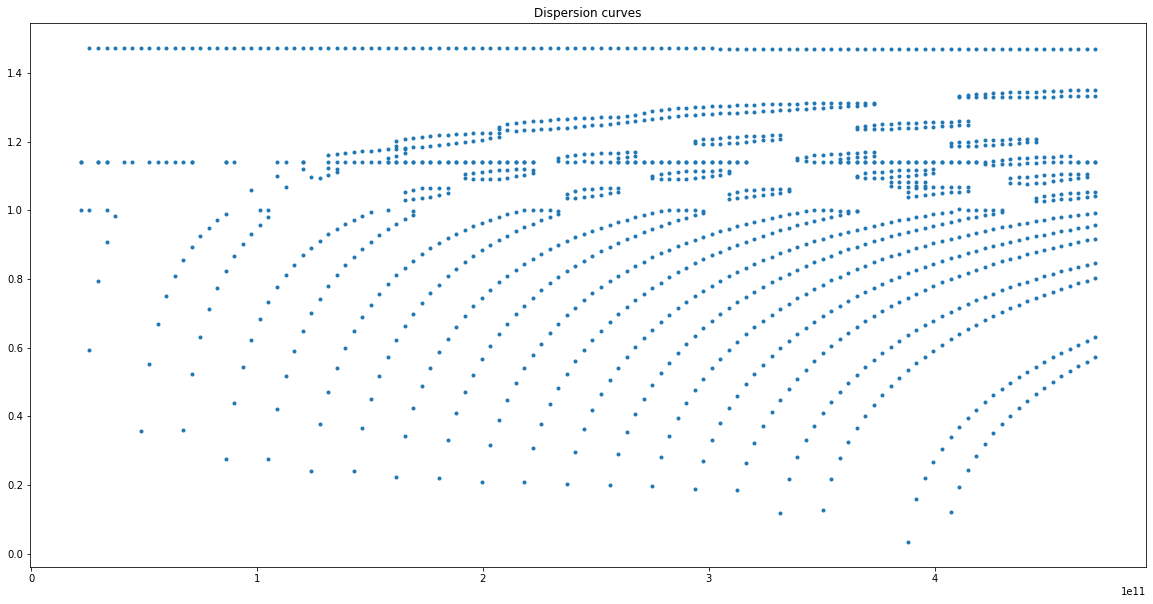

In [35]:
plot_results(results)

In [36]:
M = 10
K = 10
m = k = M

EPSABS = 1.0e-6
fs = np.linspace(3.5, 75, 120)
betas = np.linspace(BETA_BEGIN, BETA_END, int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0000000000022171
root found: 1.13995993242515
root found: 1.1400947965531283
root found: 1.4736672322309505
f = 4.100840336134453, w = 25766339747.089394 ...
root found: 0.5928957388754602
root found: 1.00000000000807
root found: 1.4736381836177346
f = 4.701680672268908, w = 29541530919.050243 ...
root found: 0.7952735379938994
root found: 1.1400461145236873
root found: 1.1401751303017136
root found: 1.4736087325633742
f = 5.302521008403361, w = 33316722091.01108 ...
root found: 0.9090363981599083
root found: 1.0001076514360214
root found: 1.1399905055985018
root found: 1.1401935260896332
root found: 1.4735793609781678
f = 5.9033613445378155, w = 37091913262.97193 ...
root found: 0.9833553788475937
root found: 1.4735503455277574
f = 6.504201680672269, w = 40867104434.93277 ...
root found: 1.1399497900201725
root found: 1.1401048053603977
root found: 1.473521823786673
f = 7.105042016806722, w = 44642295606.89361 ...
root found: 1.13993233

root found: 1.1764503722133668
root found: 1.4728009577390637
f = 25.130252100840334, w = 157898030765.7189 ...
root found: 0.5744384929200739
root found: 0.7856774780807093
root found: 0.9448088125077739
root found: 0.9999923305130207
root found: 1.139951044793508
root found: 1.140196046941291
root found: 1.153164631403855
root found: 1.1786225294845296
root found: 1.4727785497383845
f = 25.731092436974787, w = 161673221937.67975 ...
root found: 0.22206571260855637
root found: 0.6213990755928409
root found: 0.8109263039415725
root found: 0.9603975767280968
root found: 0.9999811694524322
root found: 1.139941549361647
root found: 1.140196327042191
root found: 1.159592664863885
root found: 1.179328928389121
root found: 1.1892367043661145
root found: 1.203320177791115
root found: 1.472756163709312
f = 26.331932773109244, w = 165448413109.64062 ...
root found: 0.3415644070875913
root found: 0.66213404489165
root found: 0.8336132008780213
root found: 0.9747114494329112
root found: 0.9999618

root found: 0.9909196144931238
root found: 0.9998890893889733
root found: 1.143634325640719
root found: 1.1535246220293525
root found: 1.2394922128196364
root found: 1.2654340695049398
root found: 1.4723317133326836
f = 37.747899159663866, w = 237177045376.89664 ...
root found: 0.20206565469490562
root found: 0.5241112935617194
root found: 0.6943250947867022
root found: 0.8232904485899071
root found: 0.9112329863804913
root found: 1.0355396828617842
root found: 1.046772038615585
root found: 1.1414985542617246
root found: 1.1578449212246624
root found: 1.2414916574669834
root found: 1.2664684860739472
root found: 1.4723092992414555
f = 38.34873949579832, w = 240952236548.85748 ...
root found: 0.2962845191076023
root found: 0.5606491830516401
root found: 0.7173238515792085
root found: 0.8392602863111291
root found: 0.9219275713938484
root found: 1.0356450452661334
root found: 1.0571191197657297
root found: 1.1416696377465616
root found: 1.1615352757998691
root found: 1.2434736158778317
r

root found: 0.5399970499368186
root found: 0.6781462052268843
root found: 0.7810495330157838
root found: 0.8689687280827361
root found: 0.9318752422079508
root found: 1.1005361525704942
root found: 1.1163441873423974
root found: 1.1400135231926232
root found: 1.140202916227874
root found: 1.1940332000231737
root found: 1.2093803610139995
root found: 1.2806895019670828
root found: 1.303680087252171
root found: 1.4719253942301693
f = 48.563025210084035, w = 305130486472.1919 ...
root found: 0.38108921131495904
root found: 0.567770905289832
root found: 0.6974517635511659
root found: 0.7952147684403906
root found: 0.8797697485188908
root found: 0.9396122250974525
root found: 1.1038594819007626
root found: 1.116543491334129
root found: 1.1400249560524016
root found: 1.1402029132703928
root found: 1.194984536434496
root found: 1.211231239041845
root found: 1.2825911814352189
root found: 1.3047593760436247
root found: 1.471902622537934
f = 49.16386554621849, w = 308905677644.1527 ...
root fou

root found: 1.1399397081432767
root found: 1.140207851305267
root found: 1.152309326028992
root found: 1.1670716069735856
root found: 1.3037078167529041
root found: 1.3137913883685242
root found: 1.4715585206568917
f = 58.17647058823529, w = 365533545223.56537 ...
root found: 0.36708259999401877
root found: 0.5218055870725595
root found: 0.6602000770617251
root found: 0.7501683593160683
root found: 0.8289900472383319
root found: 0.8949519656788879
root found: 0.9443287398040582
root found: 0.9985352609648007
root found: 0.9994426432138884
root found: 1.0967983186310195
root found: 1.1003529696737824
root found: 1.1399365530978012
root found: 1.1402083670788665
root found: 1.154636513980145
root found: 1.1680964253546058
root found: 1.2364435457872345
root found: 1.2436173630415706
root found: 1.305519284841911
root found: 1.3139051727228115
root found: 1.4715354272360301
f = 58.77731092436974, w = 369308736395.5262 ...
root found: 0.4024581102242231
root found: 0.5442841181423762
root 

root found: 1.0000000000141975
root found: 1.05797364712631
root found: 1.0680614996255748
root found: 1.1399174710401667
root found: 1.1402153394980477
root found: 1.1875631429656395
root found: 1.200612953238406
root found: 1.250394960108049
root found: 1.2601373919087437
root found: 1.330273953639076
root found: 1.3365275606631948
root found: 1.4712340792257823
f = 66.58823529411765, w = 418386221631.01715 ...
root found: 0.28597303400388746
root found: 0.41889766574213555
root found: 0.6671235353472393
root found: 0.7380368309182362
root found: 0.8276217660293006
root found: 0.8825164932802441
root found: 0.9354452537332345
root found: 0.981737707903598
root found: 1.0000000000144338
root found: 1.1398301340313837
root found: 1.140217888478964
root found: 1.188638846148188
root found: 1.202477929788575
root found: 1.3302572098627718
root found: 1.338548820785224
root found: 1.4712108523435374
f = 67.18907563025209, w = 422161412802.97797 ...
root found: 0.320564952596081
root found

root found: 0.9565635251046426
root found: 0.99368690515866
root found: 1.043183811992482
root found: 1.0536438636489467
root found: 1.1400412478264454
root found: 1.1402160571082183
root found: 1.3347430907670437
root found: 1.3514404665304285
root found: 1.470886917070649


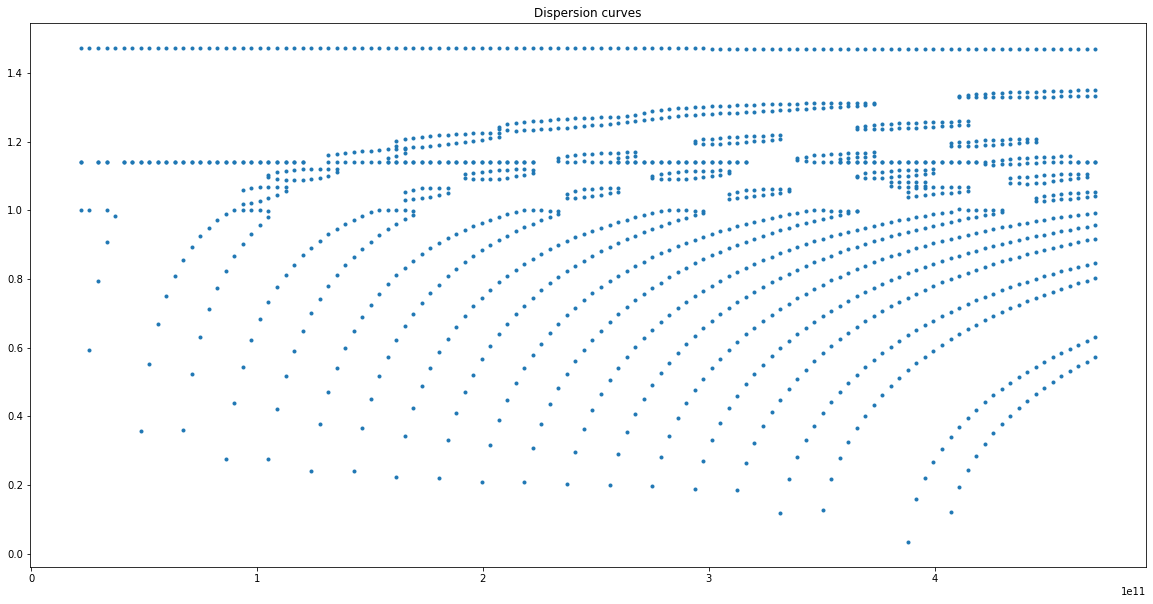

In [37]:
plot_results(results)

In [40]:
M = 15
K = 15
m = k = M

EPSABS = 1.0e-7
fs = np.linspace(3.5, 75, 120)
betas = np.linspace(BETA_BEGIN, BETA_END, int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0048025737270745
root found: 1.1386300366213122
root found: 1.140388982851856
f = 4.100840336134453, w = 25766339747.089394 ...
root found: 0.5929000731129117
root found: 1.0019449717684399
f = 4.701680672268908, w = 29541530919.050243 ...
root found: 0.795282100052861
root found: 1.1388340676514477
root found: 1.1489332840428226
f = 5.302521008403361, w = 33316722091.01108 ...
root found: 0.9090524016551026
root found: 1.0011872138366353
root found: 1.1345870706930468
root found: 1.1404471663245905
root found: 1.4767959484917683
f = 5.9033613445378155, w = 37091913262.97193 ...
root found: 0.9833985895556386
f = 6.504201680672269, w = 40867104434.93277 ...
root found: 1.1397867040963336
f = 7.105042016806722, w = 44642295606.89361 ...
root found: 1.133545625671971
f = 7.705882352941177, w = 48417486778.85446 ...
root found: 0.3584648006107367
root found: 1.4767555759096598
f = 8.306722689075631, w = 52192677950.81531 ...
root found: 0.5

root found: 1.076668568777708
root found: 1.140076868902522
root found: 1.1403142378406814
root found: 1.175570360313779
root found: 1.2149354537698513
root found: 1.4765275192995593
f = 28.134453781512605, w = 176773986625.52316 ...
root found: 0.5411831398548833
root found: 0.7584822018500691
root found: 0.8895114672042826
root found: 1.0385834639595382
root found: 1.0470451668531364
root found: 1.0636234051961737
root found: 1.0787496077069718
root found: 1.1400771635583344
root found: 1.1403145391403071
root found: 1.1808766600562852
root found: 1.2172727438437831
root found: 1.4765228530187327
f = 28.735294117647058, w = 180549177797.48398 ...
root found: 0.22200209671560472
root found: 0.5866525690998547
root found: 0.7843220065898278
root found: 0.9048680802549324
root found: 1.06362430625245
root found: 1.079919875423952
root found: 1.1400773835618652
root found: 1.1403150081538076
root found: 1.1907264312731949
root found: 1.2193134424488885
root found: 1.476518295473404
f = 2

root found: 0.868199247485822
root found: 0.941295543612816
root found: 1.0668552128879603
root found: 1.0748287348071823
root found: 1.1400530560109312
root found: 1.1531022636171762
root found: 1.2491026398315814
root found: 1.2770057584595709
root found: 1.4764527013993556
f = 40.15126050420168, w = 252277810064.74002 ...
root found: 0.4647691951374572
root found: 0.6501132309717221
root found: 0.7764646872984297
root found: 0.8813302627901389
root found: 0.9500178911199981
root found: 1.0642208911633941
root found: 1.0777888239823326
root found: 1.1400740514199603
root found: 1.1523335493580575
root found: 1.2529465450305632
root found: 1.2785459457851518
root found: 1.4764498462265159
f = 40.752100840336134, w = 256053001236.70087 ...
root found: 0.2016795877560908
root found: 0.5048910189479813
root found: 0.6748909074608239
root found: 0.7934687513512828
root found: 0.8936793061139703
root found: 0.9581784113095626
root found: 1.0636269118829353
root found: 1.0791385619624392
ro

root found: 1.0287152006297675
root found: 1.0437763036009504
root found: 1.1090896632208989
root found: 1.1168635198492165
root found: 1.1400854669568465
root found: 1.1403369128182648
root found: 1.1994126955038062
root found: 1.2131979227054583
root found: 1.2842440569324438
root found: 1.3066372453481276
root found: 1.476414434906194
f = 49.76470588235294, w = 312680868816.1136 ...
root found: 0.19163898318350078
root found: 0.4647189313727588
root found: 0.617117677632236
root found: 0.7330548592135631
root found: 0.8213831544155652
root found: 0.9000158446288765
root found: 0.9539229113506434
root found: 1.0323581960939296
root found: 1.0446850136956314
root found: 1.1400835787422683
root found: 1.1403487749203494
root found: 1.2004235958707348
root found: 1.2145606974919614
root found: 1.286541845324963
root found: 1.3077248593287782
root found: 1.476412495086419
f = 50.365546218487395, w = 316456059988.0744 ...
root found: 0.2696839299148996
root found: 0.49765946580485027
root

root found: 0.43197624642235916
root found: 0.575194505669508
root found: 0.6813124488600036
root found: 0.7694858350584227
root found: 0.8397783744246468
root found: 0.9043756574685926
root found: 0.9507573255719712
root found: 1.0237695245028346
root found: 1.0360422585799778
root found: 1.1686635363113513
root found: 1.172944805372089
root found: 1.233197616596345
root found: 1.2456719900834081
root found: 1.305866815264681
root found: 1.320872313860562
root found: 1.476388075584016
f = 59.3781512605042, w = 373083927567.487 ...
root found: 0.25647076520248485
root found: 0.4626805150679814
root found: 0.5961261923592454
root found: 0.6969729340416349
root found: 0.7817222511720132
root found: 0.8493682689780891
root found: 0.9121198280502875
root found: 0.9565106974321724
root found: 1.0254113059714074
root found: 1.0397895978084155
root found: 1.0995413540584944
root found: 1.1091805897460445
root found: 1.167435316760716
root found: 1.1761466774139728
root found: 1.23414179450860

root found: 1.4763723387998693
f = 67.18907563025209, w = 422161412802.97797 ...
root found: 0.07607841765890369
root found: 0.3750995926579465
root found: 0.5184991611458467
root found: 0.6255039826169349
root found: 0.7106840673852491
root found: 0.7841793578331595
root found: 0.8445143270714528
root found: 0.9006868042533713
root found: 0.9429538101857775
root found: 0.9898286567459044
root found: 1.0065932332045389
root found: 1.0651182360636233
root found: 1.0804936089389519
root found: 1.1335994055626728
root found: 1.1423917753176458
root found: 1.323500425448232
root found: 1.3401642329683987
root found: 1.4763712866168417
f = 67.78991596638656, w = 425936603974.93884 ...
root found: 0.18210352452295567
root found: 0.4069900446411572
root found: 0.5398329452925457
root found: 0.6415811222335739
root found: 0.7233517162517098
root found: 0.7944385869841272
root found: 0.8528104978692173
root found: 0.9075585549588017
root found: 0.9482875033704248
root found: 0.9944466393423679


root found: 1.0051485272555873
root found: 1.0089350469768221
root found: 1.0993167888578734
root found: 1.1120289034923936
root found: 1.2700781372241998
root found: 1.2795639180399825
root found: 1.3328362221012784
root found: 1.3463032449096082
root found: 1.4763600659585545
f = 75.0, w = 471238898038.46893 ...
root found: 0.28233148936734687
root found: 0.4437686750861851
root found: 0.5576429566606305
root found: 0.6469678440739753
root found: 0.7212223644818272
root found: 0.7860489031256948
root found: 0.8405333276608972
root found: 0.8913830005177836
root found: 0.931442598472889
root found: 0.9739492871530091
root found: 0.9978927583039039
root found: 1.0046419524159174
root found: 1.0092837930654388
root found: 1.1002583723944073
root found: 1.1131843641145738
root found: 1.271235830093801
root found: 1.2800985090452612
root found: 1.3336980893718746
root found: 1.347086248498355
root found: 1.4763592351094619


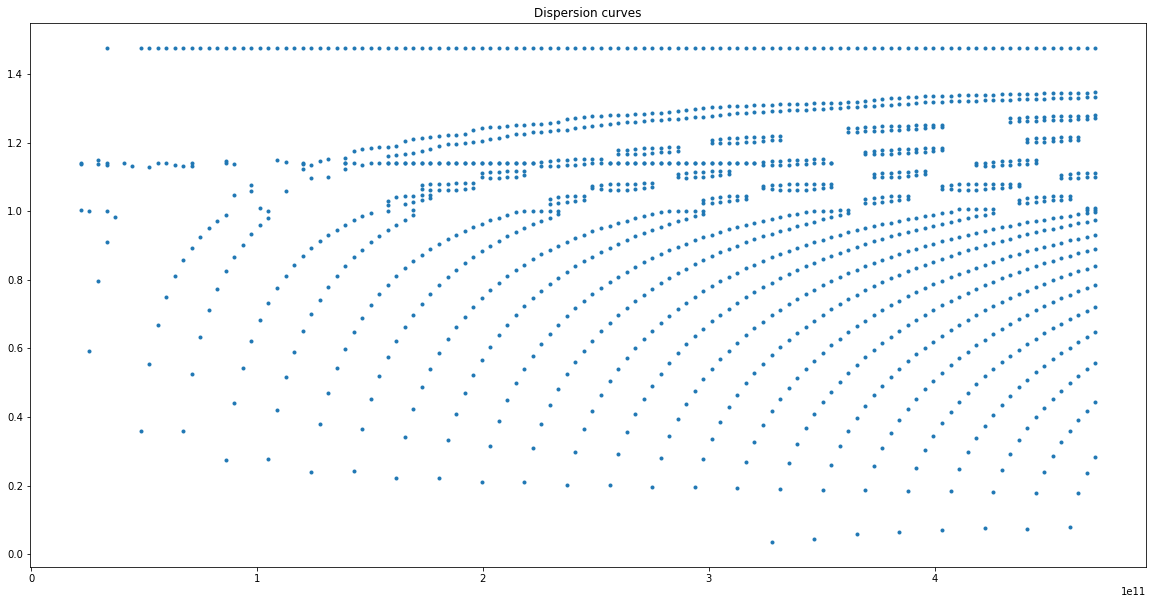

In [41]:
plot_results(results)

In [44]:
M = 20
K = 20
m = k = M

EPSABS = 1.0e-7
fs = np.linspace(3.5, 75, 120)
betas = np.linspace(BETA_BEGIN, BETA_END, int(BETA_POINTS))
results = get_results(fs, betas, True)

f = 3.5, w = 21991148575.12855 ...
root found: 1.0000000000078964
f = 4.100840336134453, w = 25766339747.089394 ...
root found: 0.592901150791949
root found: 1.0000000000131957
root found: 1.0372130786290912
f = 4.701680672268908, w = 29541530919.050243 ...
root found: 0.7952842729748596
f = 5.302521008403361, w = 33316722091.01108 ...
root found: 0.9090566114101406
root found: 1.0001460939934659
root found: 1.038807572829879
root found: 1.480657405856454
f = 5.9033613445378155, w = 37091913262.97193 ...
root found: 0.9834111161168291
f = 6.504201680672269, w = 40867104434.93277 ...
root found: 1.0391768389113096
f = 7.105042016806722, w = 44642295606.89361 ...
root found: 1.0393270062920608
f = 7.705882352941177, w = 48417486778.85446 ...
root found: 0.358464913088674
f = 8.306722689075631, w = 52192677950.81531 ...
root found: 0.5533901729131512
root found: 1.038036266467257
root found: 1.0393494435736197
f = 8.907563025210084, w = 55967869122.77615 ...
root found: 0.6693321526958415

root found: 1.214856536170811
root found: 1.4806572450632558
f = 28.134453781512605, w = 176773986625.52316 ...
root found: 0.5411837989069641
root found: 0.7584829336192169
root found: 0.8895182625972228
root found: 1.006108184186791
root found: 1.0663265318728314
root found: 1.0849820478357954
root found: 1.1185139859391378
root found: 1.140228800188545
root found: 1.1521831744973305
root found: 1.1818356693797025
root found: 1.217214999518172
root found: 1.480657241798398
f = 28.735294117647058, w = 180549177797.48398 ...
root found: 0.22200664324422614
root found: 0.5866534115075595
root found: 0.7843227487076309
root found: 0.9048760638978538
root found: 1.0060686127201512
root found: 1.0717808926788837
root found: 1.085665121066432
root found: 1.1184272426357154
root found: 1.1402288098882862
root found: 1.1521775904097546
root found: 1.185481480735783
root found: 1.219255444868666
root found: 1.4806572385684582
f = 29.33613445378151, w = 184324368969.44482 ...
root found: 0.3321

root found: 1.0845199865294948
root found: 1.118477283515027
root found: 1.1295041412999265
root found: 1.14023170524207
root found: 1.2402130459746228
root found: 1.2667125533531736
root found: 1.4780995051933388
f = 38.34873949579832, w = 240952236548.85748 ...
root found: 0.2963536024264338
root found: 0.5607668212746634
root found: 0.7173403980411943
root found: 0.83928330176855
root found: 0.9219883549179883
root found: 1.000000000014771
root found: 1.032112926064712
root found: 1.0461176008308377
root found: 1.0557134458935302
root found: 1.0846758195587616
root found: 1.1187743038725078
root found: 1.1301559529069332
root found: 1.1402326778436211
root found: 1.1546252378179356
root found: 1.160601862635987
root found: 1.2444396530821622
root found: 1.2680929601644217
root found: 1.4780951581989363
f = 38.94957983193277, w = 244727427720.81833 ...
root found: 0.36411972448053487
root found: 0.5934972959026259
root found: 0.7385615453577615
root found: 0.8542136081426265
root fou

root found: 0.6356692871431785
root found: 0.7501601841978301
root found: 0.8457491432284092
root found: 0.9150946822108271
root found: 0.9857615454935423
root found: 1.0158579651824264
root found: 1.0249071425845944
root found: 1.0519337316111843
root found: 1.084949281320013
root found: 1.1168353858981048
root found: 1.129244797933616
root found: 1.1399389380020795
root found: 1.1402294983090828
root found: 1.1523234873247723
root found: 1.1838294316806826
root found: 1.1959858766389808
root found: 1.275689168723674
root found: 1.2957523581617576
root found: 1.4780350596882248
f = 47.36134453781512, w = 297580104128.27014 ...
root found: 0.2767703972288328
root found: 0.5097690784299677
root found: 0.6579099112810938
root found: 0.7661394548612421
root found: 0.8577705457808396
root found: 0.923753410678892
root found: 0.9926606970477274
root found: 1.0173150226443428
root found: 1.0287914798366866
root found: 1.0522490723551494
root found: 1.0847765086228573
root found: 1.1158459076

root found: 0.9932753571651086
root found: 1.0059401628843765
root found: 1.052391738419303
root found: 1.0864418238709157
root found: 1.1197871839164117
root found: 1.1269252017057214
root found: 1.140238599106773
root found: 1.2964943515413305
root found: 1.3142384303551327
root found: 1.4779843510455934
f = 54.57142857142857, w = 342882398191.8003 ...
root found: 0.36787086361743926
root found: 0.5401038091210228
root found: 0.6636338222573946
root found: 0.7582698553970115
root found: 0.8397177909860135
root found: 0.90195889014613
root found: 0.9637027057040829
root found: 0.9977920349019609
root found: 1.0067350646237248
root found: 1.0519041471649713
root found: 1.086842365123843
root found: 1.1198721879048525
root found: 1.1266838160665138
root found: 1.1400217914564073
root found: 1.2976372637617173
root found: 1.3158614350066156
root found: 1.477980148281637
f = 55.17226890756302, w = 346657589363.7611 ...
root found: 0.0451947319701693
root found: 0.40754369670885476
root fo

root found: 0.8152184666862353
root found: 0.8757301004232395
root found: 0.9335722984605437
root found: 0.9722721073385622
root found: 1.006130324805325
root found: 1.0391602295506852
root found: 1.0413666386704405
root found: 1.0553717644578489
root found: 1.0854642064147673
root found: 1.11773912959361
root found: 1.124350306669389
root found: 1.1368577484230817
root found: 1.1402303100968323
root found: 1.152506221165526
root found: 1.2379834659132332
root found: 1.2440735868169863
root found: 1.3117243240558631
root found: 1.3314005710246457
root found: 1.4779340809216017
f = 61.78151260504202, w = 388184692255.3304 ...
root found: 0.18511734344619954
root found: 0.4237330089616655
root found: 0.5620305393073208
root found: 0.6680138598884962
root found: 0.7520796701096846
root found: 0.8254226450598725
root found: 0.8837803707771993
root found: 0.9401759388136802
root found: 0.9770521964705613
root found: 1.0060965253074545
root found: 1.0564142265390162
root found: 1.08550737326

root found: 0.8528226664208904
root found: 0.9075760321395059
root found: 0.9483158697312076
root found: 0.9944648204519441
root found: 1.0523489051154482
root found: 1.0874330480828571
root found: 1.1515270381001133
root found: 1.2558219855306822
root found: 1.265725776547625
root found: 1.3232641024909868
root found: 1.3387803101867914
root found: 1.4778882165822997
f = 68.39075630252101, w = 429711795146.8997 ...
root found: 0.24501841097302668
root found: 0.43632996167581023
root found: 0.5598666949876225
root found: 0.6569454164142357
root found: 0.7354957142202659
root found: 0.8043455479874321
root found: 0.8608020477692793
root found: 0.9142048678452261
root found: 0.9534399554207166
root found: 0.9990280763881559
root found: 1.0524933077477223
root found: 1.0877787359351654
root found: 1.1198732064610777
root found: 1.1200696849702176
root found: 1.1507196813553964
root found: 1.2570024014032408
root found: 1.2663824348409125
root found: 1.3240769467778346
root found: 1.339628

root found: 1.007751236514241
root found: 1.058830906919944
root found: 1.086251300897014
root found: 1.16501366070639
root found: 1.27390466751117
root found: 1.2829388977735574
root found: 1.333800624418237
root found: 1.3516739115978897
root found: 1.477842445054729
f = 75.0, w = 471238898038.46893 ...
root found: 0.2847755618291575
root found: 0.4464086854081377
root found: 0.5580729305089316
root found: 0.6476396591838227
root found: 0.7213140356955899
root found: 0.7862134787434265
root found: 0.8405922329957555
root found: 0.8914703358343763
root found: 0.9314657554219162
root found: 0.9739800203015709
root found: 0.9979972351945401
root found: 1.007394676129871
root found: 1.0597630957619923
root found: 1.0863335028054606
root found: 1.1051782641980492
root found: 1.1136263914195208
root found: 1.16599105764854
root found: 1.2745506549100682
root found: 1.2839519982823129
root found: 1.3349042847208976
root found: 1.3523472906611749
root found: 1.4778382855569234


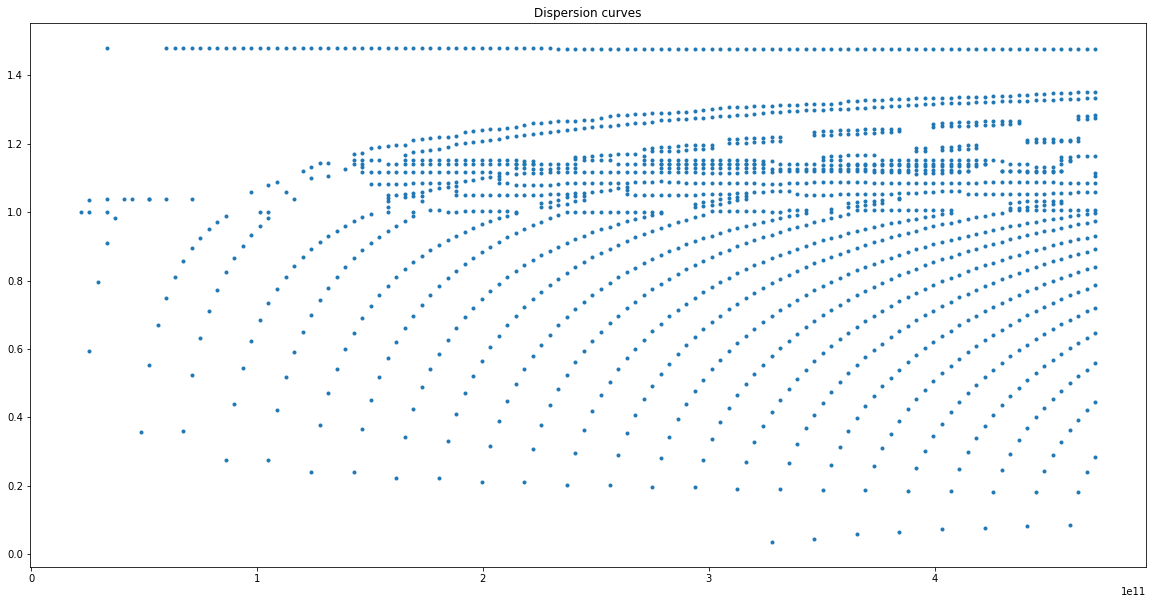

In [45]:
plot_results(results)